# Import dependencies

In [1]:
import os
import re
import gc
import json
from tqdm.auto import tqdm

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

# Import more dependencies

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import segmentation_models_pytorch as smp
import ttach as tta


from wheat_infer_split_utils import *

# Configuration

In [3]:
class Config:
    arch = 'resnest50'
    heads = {'hm': 1,
             'wh': 2,
             'reg': 2}
    head_conv = 64
    reg_offset = True
    cat_spec_wh = False
    load_model = '../exp/ctdet/resnest50_fpn_ms_crop/model_last.pth'
    
    # Image
    img_size = 1024
    in_scale = 1024 / img_size
    down_ratio = 4
    
    mean = [0.315290, 0.317253, 0.214556], 
    std = [0.245211, 0.238036, 0.193879]
    num_classes = 1
    
    pad = 31
    
    # Test
    
    batch_size = 8
    K = 128
    max_per_image = 128
    
    fix_res = False
    test_scales = [1.]
    flip_test = False
    nms = False
    gpus = [0]
    
opt = Config()

# Create model & load pretrained weight

In [4]:
class PoseFPNNet(nn.Module):
    def __init__(self, base_name, heads, head_conv=256):
        super(PoseFPNNet, self).__init__()

        base = smp.FPN(base_name, encoder_weights=None, decoder_dropout=0, decoder_segmentation_channels=64, upsampling=1)
        self.encoder = base.encoder
        self.decoder = base.decoder

        self.heads = heads
        for head in self.heads:
            classes = self.heads[head]
            fc = nn.Sequential(
                nn.Conv2d(64, head_conv,
                          kernel_size=3, padding=1, bias=True),
                nn.ReLU(inplace=True),
                nn.Conv2d(head_conv, classes,
                          kernel_size=1, stride=1,
                          padding=0, bias=True))
            if 'hm' in head:
                fc[-1].bias.data.fill_(-2.19)
            else:
                fill_fc_weights(fc)
            self.__setattr__(head, fc)

        del base

    def forward(self, x):
        features = self.encoder(x)
        x = self.decoder(*features)

        z = {}
        for head in self.heads:
            z[head] = self.__getattr__(head)(x)
        return [z]

    def freeze_backbone(self):
        for p in self.encoder.parameters():
            p.requires_grad = False
        for p in self.decoder.parameters():
            p.requires_grad = False

    def freeze_head(self, heads):
        for head in heads:
            for p in self.__getattr__(head).parameters():
                p.requires_grad = False

    def set_mode(self, mode, is_freeze_bn=False):
        self.mode = mode
        if mode in ['eval', 'valid', 'test']:
            self.eval()
        elif mode in ['train']:
            self.train()
            if is_freeze_bn==True: ##freeze
                for m in self.modules():
                    if isinstance(m, nn.BatchNorm2d):
                        m.eval()
                        # m.weight.requires_grad = False
                        # m.bias.requires_grad   = False

def fill_fc_weights(layers):
    for m in layers.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.normal_(m.weight, std=0.001)
            # torch.nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')
            # torch.nn.init.xavier_normal_(m.weight.data)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)


def get_pose_net(base_name, heads, head_conv):
    model = PoseFPNNet(base_name, heads, head_conv)
    return model

In [5]:
model = get_pose_net(opt.arch, opt.heads, opt.head_conv)
device = torch.device('cuda') if opt.gpus[0] >= 0 else torch.device('cpu')
checkpoint = torch.load(opt.load_model, map_location=device)
model.load_state_dict(checkpoint['state_dict'])
model.to(device)

del checkpoint
gc.collect()

0

# Preapre labels

In [6]:
DIR_INPUT = '../../input'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

train_df = pd.read_csv(f'{DIR_INPUT}/train.csv')
train_df.shape

(147793, 5)

In [7]:
train_df['x'] = -1
train_df['y'] = -1
train_df['w'] = -1
train_df['h'] = -1

def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

train_df[['x', 'y', 'w', 'h']] = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x)))
train_df.drop(columns=['bbox'], inplace=True)
train_df['x'] = train_df['x'].astype(np.float)
train_df['y'] = train_df['y'].astype(np.float)
train_df['w'] = train_df['w'].astype(np.float)
train_df['h'] = train_df['h'].astype(np.float)

train_df.head()

,image_id,width,height,source,x,y,w,h
0,b6ab77fd7,1024,1024,usask_1,834.0,222.0,56.0,36.0
1,b6ab77fd7,1024,1024,usask_1,226.0,548.0,130.0,58.0
2,b6ab77fd7,1024,1024,usask_1,377.0,504.0,74.0,160.0
3,b6ab77fd7,1024,1024,usask_1,834.0,95.0,109.0,107.0
4,b6ab77fd7,1024,1024,usask_1,26.0,144.0,124.0,117.0


# Define test dataset

In [8]:
class WheatDatasetTest(torch.utils.data.Dataset):
    def __init__(self, opt, image_dir, img_id):
        
        self.opt = opt
        
        self.image_dir = image_dir
        self.img_id = img_id
        
    def __len__(self):
        return len(self.img_id)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.img_id[idx])
        return img_path, self.img_id[idx]

In [9]:
with open('../data/wheat/annotations/val.json', 'r') as f:
    val_data_dict = json.load(f)
val_img_ids = [d['file_name'] for d in val_data_dict['images']]

In [10]:
testdataset = WheatDatasetTest(opt, '../data/wheat/images', val_img_ids)
print('Total number of images in valid set: {}'.format(len(testdataset)))

Total number of images in valid set: 675


In [11]:
detector = CtdetDetector(opt, model)

Creating model...


In [12]:
img_path, _ = testdataset[0]
image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB) # RGB

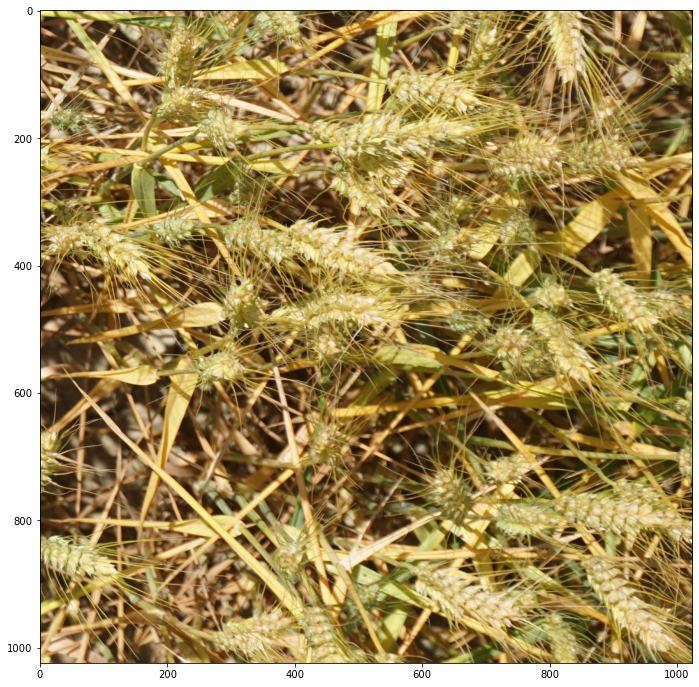

In [13]:
plt.figure(figsize=(12, 12))
plt.imshow(image)
plt.show()

In [14]:
images, meta = detector.pre_process(image, scale=1, split=2, meta=None)

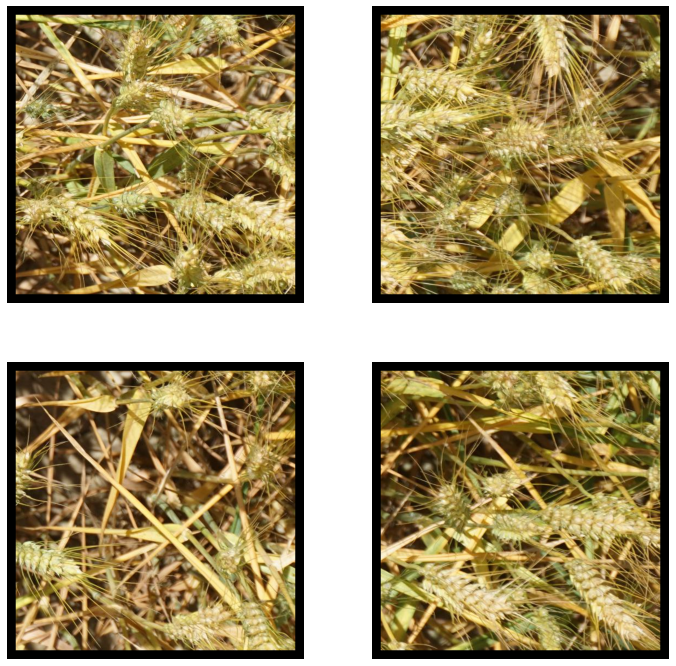

In [15]:
plt.figure(figsize=(12, 12))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.axis('off')
    plt.imshow(((images[i, ...].numpy().transpose(1, 2, 0)*detector.std + detector.mean)*255).astype(np.uint8))
plt.show()

In [16]:
images = images.cuda()
hm_assembled, wh_assembled, reg_assembled = detector.process(images, 2, return_time=False)

C:\Softwares\Miniconda3\envs\kaggle-wheat\lib\site-packages\resnest\torch\splat.py:79: UserWarning: Mixed memory format inputs detected while calling the operator. The operator will output contiguous tensor even if some of the inputs are in channels_last format. (Triggered internally at  ..\aten\src\ATen\native\TensorIterator.cpp:917.)
  out = sum([att*split for (att, split) in zip(attens, splited)])


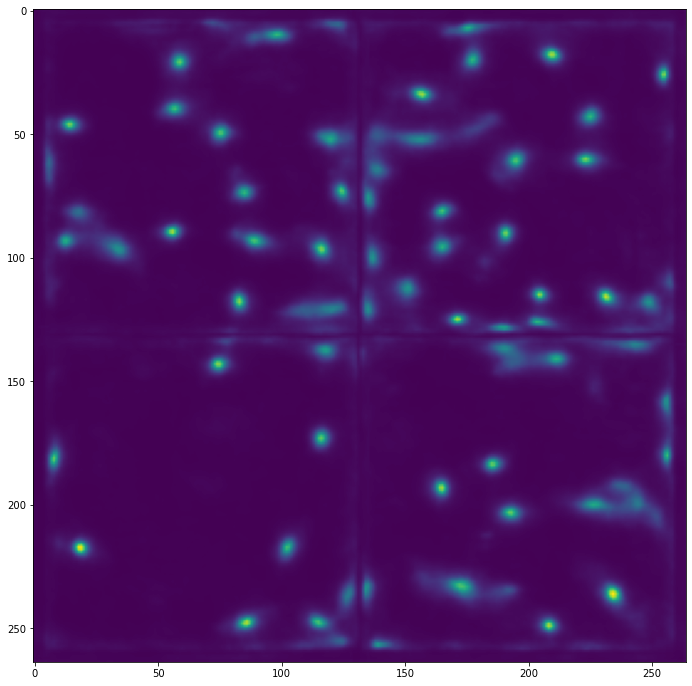

In [18]:
plt.figure(figsize=(12, 12))
plt.imshow(hm_assembled[0, 0])
plt.show()

# Validation

In [ ]:
import numba
import ast

from numba import jit
from typing import List, Union, Tuple

In [ ]:
def calculate_iou(gt, pr, form='pascal_voc') -> float:
    """Calculates the Intersection over Union.

    Args:
        gt: (np.ndarray[Union[int, float]]) coordinates of the ground-truth box
        pr: (np.ndarray[Union[int, float]]) coordinates of the prdected box
        form: (str) gt/pred coordinates format
            - pascal_voc: [xmin, ymin, xmax, ymax]
            - coco: [xmin, ymin, w, h]
    Returns:
        (float) Intersection over union (0.0 <= iou <= 1.0)
    """
    if form == 'coco':
        gt = gt.copy()
        pr = pr.copy()

        gt[2] = gt[0] + gt[2]
        gt[3] = gt[1] + gt[3]
        pr[2] = pr[0] + pr[2]
        pr[3] = pr[1] + pr[3]

    # Calculate overlap area
    dx = min(gt[2], pr[2]) - max(gt[0], pr[0]) + 1
    
    if dx < 0:
        return 0.0
    
    dy = min(gt[3], pr[3]) - max(gt[1], pr[1]) + 1

    if dy < 0:
        return 0.0

    overlap_area = dx * dy

    # Calculate union area
    union_area = (
            (gt[2] - gt[0] + 1) * (gt[3] - gt[1] + 1) +
            (pr[2] - pr[0] + 1) * (pr[3] - pr[1] + 1) -
            overlap_area
    )

    return overlap_area / union_area

In [ ]:
def find_best_match(gts, pred, pred_idx, threshold = 0.5, form = 'pascal_voc', ious=None) -> int:
    """Returns the index of the 'best match' between the
    ground-truth boxes and the prediction. The 'best match'
    is the highest IoU. (0.0 IoUs are ignored).

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        pred: (List[Union[int, float]]) Coordinates of the predicted box
        pred_idx: (int) Index of the current predicted box
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (int) Index of the best match GT box (-1 if no match above threshold)
    """
    best_match_iou = -np.inf
    best_match_idx = -1

    for gt_idx in range(len(gts)):
        
        if gts[gt_idx][0] < 0:
            # Already matched GT-box
            continue
        
        iou = -1 if ious is None else ious[gt_idx][pred_idx]

        if iou < 0:
            iou = calculate_iou(gts[gt_idx], pred, form=form)
            
            if ious is not None:
                ious[gt_idx][pred_idx] = iou

        if iou < threshold:
            continue

        if iou > best_match_iou:
            best_match_iou = iou
            best_match_idx = gt_idx

    return best_match_idx

def calculate_precision(gts, preds, threshold = 0.5, form = 'coco', ious=None) -> float:
    """Calculates precision for GT - prediction pairs at one threshold.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (float) Precision
    """
    n = len(preds)
    tp = 0
    fp = 0
    
    # for pred_idx, pred in enumerate(preds_sorted):
    for pred_idx in range(n):

        best_match_gt_idx = find_best_match(gts, preds[pred_idx], pred_idx,
                                            threshold=threshold, form=form, ious=ious)

        if best_match_gt_idx >= 0:
            # True positive: The predicted box matches a gt box with an IoU above the threshold.
            tp += 1
            # Remove the matched GT box
            gts[best_match_gt_idx] = -1

        else:
            # No match
            # False positive: indicates a predicted box had no associated gt box.
            fp += 1

    # False negative: indicates a gt box had no associated predicted box.
    fn = (gts.sum(axis=1) > 0).sum()

    return tp / (tp + fp + fn)


def calculate_image_precision(gts, preds, thresholds = (0.5, ), form = 'coco') -> float:
    """Calculates image precision.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        thresholds: (float) Different thresholds
        form: (str) Format of the coordinates

    Return:
        (float) Precision
    """
    n_threshold = len(thresholds)
    image_precision = 0.0
    
    ious = np.ones((len(gts), len(preds))) * -1
    # ious = None

    for threshold in thresholds:
        precision_at_threshold = calculate_precision(gts.copy(), preds, threshold=threshold,
                                                     form=form, ious=ious)
        image_precision += precision_at_threshold / n_threshold

    return image_precision

In [ ]:
detector = CtdetDetector(opt, model)
threshold = 0.3

validation_image_precisions = []
# iou_thresholds = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
iou_thresholds = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75]

for img_path, img_id in tqdm(testdataset):
    
    ret = detector.run(img_path)
    results = ret['results'][1]
    results = results[results[:, 4] > threshold]

    preds = results[:, :4]
    preds = np.clip(preds, 0, 1024)
    preds[:, 2] -= preds[:, 0]
    preds[:, 3] -= preds[:, 1]
    preds = preds.round().astype(int)

    scores = results[:, 4]
    
    
    sample_id = os.path.splitext(img_id)[0]

    gt_boxes = train_df[train_df['image_id'] == sample_id][['x', 'y', 'w', 'h']].values
    gt_boxes = gt_boxes.astype(np.int)

    
    # Sort highest confidence -> lowest confidence
    preds_sorted_idx = np.argsort(scores)[::-1]
    preds_sorted = preds[preds_sorted_idx]

    
    image_precision = calculate_image_precision(gt_boxes, preds_sorted,
                                                thresholds=iou_thresholds,
                                                form='coco')
    
    validation_image_precisions.append(image_precision)
    
print("Validation IOU: {0:.4f}".format(np.mean(validation_image_precisions)))

In [ ]:
# ms+crop: Validation IOU: 0.6725 

## Validation IOU: 0.6804

flip_lr: 0.6859